IMPORTING LIBRARIES

In [33]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pyplot import figure, show
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import missingno as msno
import warnings
warnings.filterwarnings('ignore')


ADD AND VIEW DATASET

In [9]:
df =pd.read_csv (r'D:\Datasets\PIMA.csv')

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
df.shape

(768, 9)

In [50]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,28.609375,148.888587,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.666603,100.472514,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,88.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.609375,130.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,34.000000,175.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


HANDLING DATASET

In [13]:
features =df.columns 
cols=(df[features]==0).sum()
print(cols)


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [14]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] =df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [15]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<Axes: >

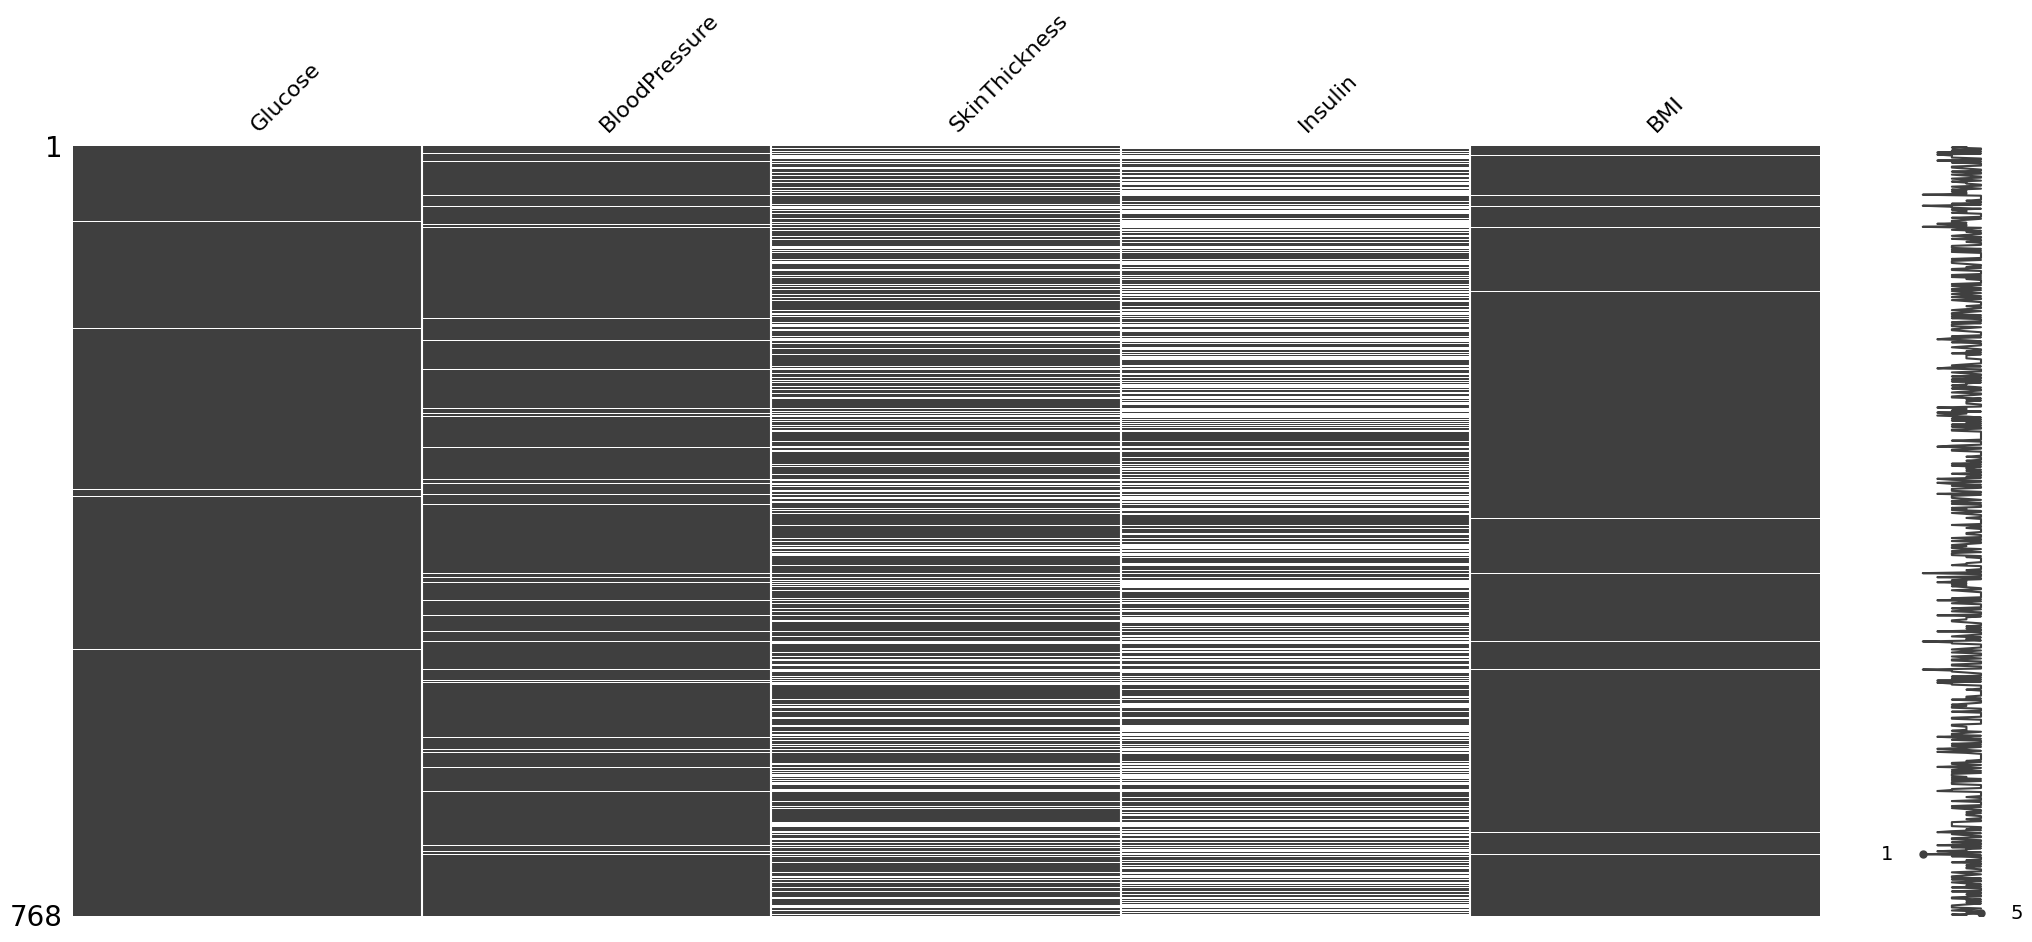

In [20]:
msno.matrix(df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])

In [35]:
df['Glucose'].fillna(df['Glucose'].median(), inplace =True)
df['BloodPressure'].fillna(df['BloodPressure'].median(), inplace =True)
df['BMI'].fillna(df['BMI'].median(), inplace =True)

by_Glucose_Age_Insulin_Grp = df.groupby(['Glucose'])
def fill_Insulin(series):
    return series.fillna(series.median()) 
df['Insulin'] = by_Glucose_Age_Insulin_Grp['Insulin'].transform(fill_Insulin)
df['Insulin'] =df['Insulin'].fillna(df['Insulin'].mean())

by_BMI_Insulin = df.groupby(['BMI'])
def fill_SkinThickness(series):
    return series.fillna(series.median())
df['SkinThickness'] = by_BMI_Insulin['SkinThickness'].transform(fill_SkinThickness)
df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace =True)


In [36]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

VISUALIZATION

Samples of diabetic people:  268
Samples of healthy people:  500


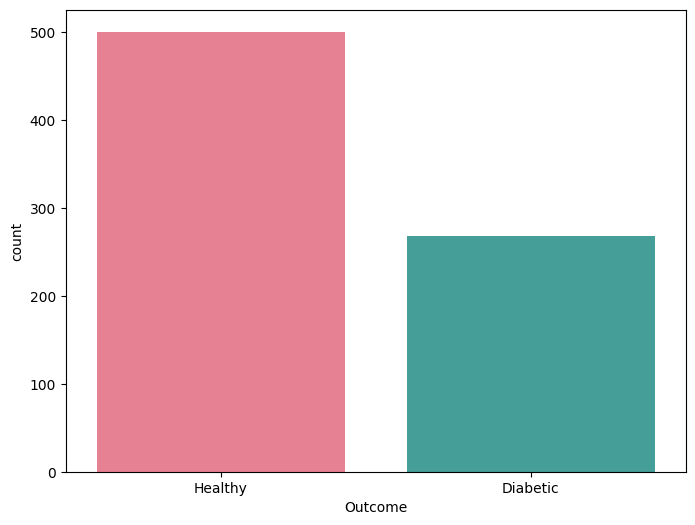

In [41]:
figure(figsize =(8,6))
ax= sns.countplot(x=df['Outcome'], data=df, palette='husl') 
ax.set_xticklabels(["Healthy", "Diabetic"])
healthy, diabetics= df['Outcome'].value_counts().values
print("Samples of diabetic people: ", diabetics)
print("Samples of healthy people: ", healthy)

CHECK OUTLIERS

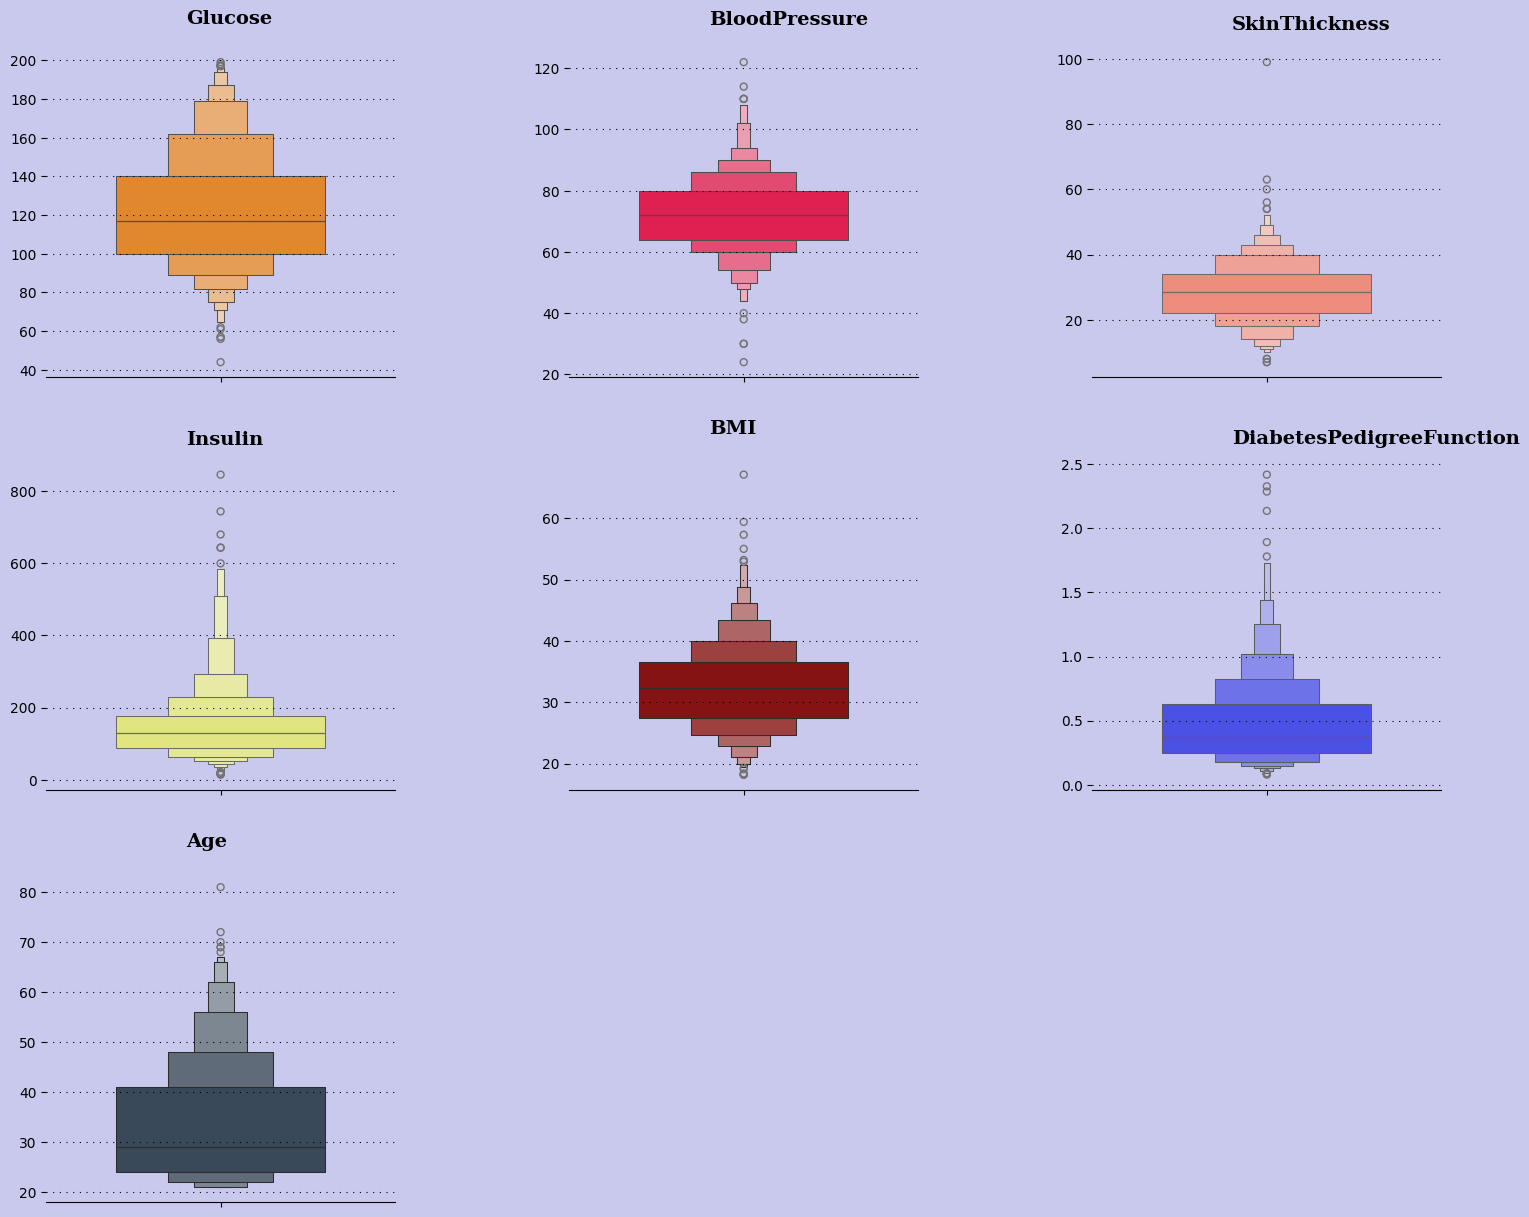

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame containing the data

fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.5, hspace=0.25)

# Define color palette for each box
color_palette = ["#ff8811", "#ff0040", "#ff7f6c", "#f0f66e", "#990000", "#3339FF", "#34495E"]

# Define background color
background_color = "#c9c9ee"

fig.patch.set_facecolor(background_color)

# Define the axes for each subplot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])

# Set background color for each subplot
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.set_facecolor(background_color)

# Iterate over each subplot to create boxenplot and set text
for i, feature in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']):
    ax = locals()[f'ax{i+1}']  # Get the current axis
    ax.text(-0.1, df[feature].max() * 1.1, feature, fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
    sns.boxenplot(ax=ax, y=df[feature], palette=[color_palette[i]], width=0.6)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    for s in ["top", "right", "left"]:
        ax.spines[s].set_visible(False)

# Remove the last empty subplot
fig.delaxes(ax8)

plt.show()


COORELATION MATRIX

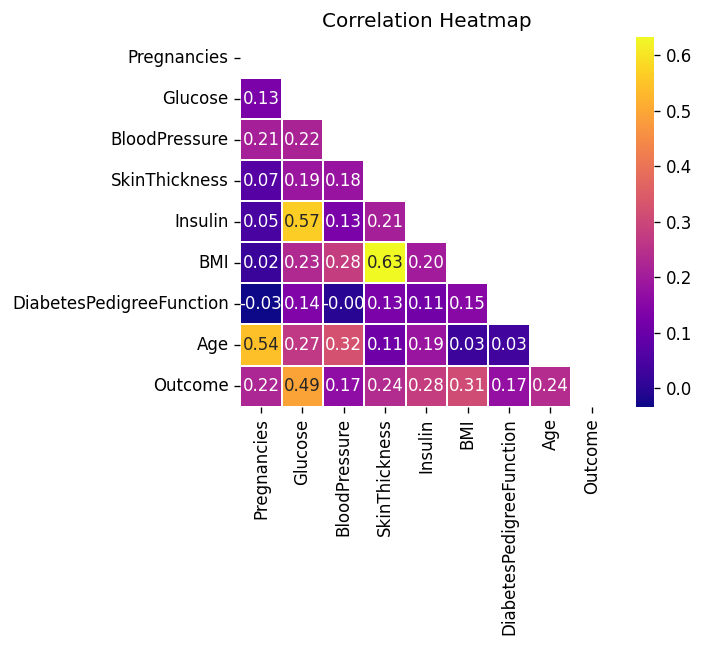

In [51]:
plt.figure(dpi = 120,figsize= (5,4))
mask = np.triu(np.ones_like(df.corr(),dtype = bool))
sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

SPLIT DATASETS

In [53]:
x = df.iloc[:, :-1].values 
y = df.iloc[:, -1].values

In [83]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.20, random_state= 0)

SCALING

In [84]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 
x_train = sc.fit_transform(x_train) 
x_test = sc.transform(x_test) 

In [85]:
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score,auc

SHOWING ACCURACY OF DIFFERENT MODELS

In [86]:
from sklearn.svm import SVC
model=SVC(kernel='rbf') 
model.fit(x_train,y_train)

y_pred=model.predict(x_test) 
accuracy_score(y_test,y_pred)


0.7792207792207793

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       107
           1       0.67      0.55      0.60        47

    accuracy                           0.78       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.77      0.78      0.77       154



In [88]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()
classifier.fit(x_train,y_train)

Y_pred=classifier.predict(x_test)
accuracy_score(y_test,Y_pred)

0.8181818181818182

In [89]:
print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       107
           1       0.73      0.64      0.68        47

    accuracy                           0.82       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.81      0.82      0.81       154



In [90]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3) 
clf.fit(x_train,y_train) 
print(clf.score(x_test,y_test))

0.7207792207792207


In [91]:
y_pred=clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       107
           1       0.55      0.47      0.51        47

    accuracy                           0.72       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.71      0.72      0.71       154



The random forest model performs exceptionally well with high accuracy, precision, recall, and F1 score. It is highly recommended for classification tasks.

ENTER DETAILS AND CHECK MODEL


In [100]:
print("Enter the following details:")
pregnancy=float(input("No of Pregnancy: "))
glucose = float(input("Glucose Level: "))
blood_pressure = float(input("Blood Pressure: "))
skin_thickness = float(input("Skin Thickness: "))
insulin = float(input("Insulin: "))
bmi = float(input("BMI: "))
diabetes_pedigree_function = float(input("Diabetes Pedigree Function: "))
age = float(input("Age: "))

# Scale the input data
user_input = sc.transform([[pregnancy,glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree_function, age]])

# Make predictions
prediction = classifier.predict(user_input)

if prediction[0] == 0:
    print("Prediction: Healthy")
else:
    print("Prediction: Diabetic")

Enter the following details:


No of Pregnancy:  6
Glucose Level:  148
Blood Pressure:  72
Skin Thickness:  35
Insulin:  0
BMI:  33.6
Diabetes Pedigree Function:  0.6
Age:  50


Prediction: Diabetic
